Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name, email and UFID.
Please do not modify instruction cells or any cells with automated tests (marked with `[ASSERTS]`). Note: you can add new cells if you need them, but answers must be in the cells with `YOUR CODE HERE` or "YOUR ANSWER HERE" comments.

---

## Homework 4: Training Neural Networks

## Preamble: Write your Name, Email and UFID

In [1]:
NAME = 'Tre\' Jeter'
EMAIL = 't.jeter@ufl.edu'
UFID = 19469876

# YOUR CODE HERE
# raise NotImplementedError()

print('Homework 4 -- name: {}, email: {}, UFID: {}\n'.format(NAME, EMAIL, UFID))

Homework 4 -- name: Tre' Jeter, email: t.jeter@ufl.edu, UFID: 19469876



In [2]:
""" [ASSERTS] Check that your name, email, and UFID is filled in."""
assert NAME != '' and NAME != 'Your name here.' and len(NAME) > 3
assert EMAIL != '' and EMAIL != 'Your email here.' and len(EMAIL) > 7
assert type(UFID) == int and UFID != 12345678 and UFID >= 10000000 and UFID <= 99999999

## Academic Integrity

### <span style="color:red;">This is an individual assignment. Academic integrity violations (i.e., cheating, plagiarism) will be reported to SCCR!</span><br/>
#### The official CISE policy recommended for such offenses is a course grade of E. Additional sanctions may be imposed by SCCR such as marks on your permanent educational transcripts, dismissal or expulsion.
#### Reminder of the Honor Pledge: On all work submitted for credit by Students at the University of Florida, the following pledge is either required or implied: *"On my honor, I have neither given nor received unauthorized aid in doing this assignment."*

#### Acknowledgement: Do you acknowledge and understand the academic integrity warning above? 

In [3]:
academic_integrity_acknowledgement = True
# YOUR CODE HERE
# raise NotImplementedError()

In [4]:
""" [ASSERTS] Check that you acknowledge the academic integrity warning, you understand it and have been reminded of the UF Honor Pledge."""
assert academic_integrity_acknowledgement

#### The following cell's code (import statements etc.) is provided for you and you should not need to change it.

In [5]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

------------
### Python version: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.20.3
### Scikit-learn version: 1.4.0
### Tensorflow version: 2.8.0
------------


#### This is the seed we will use, do not change it.

In [6]:
# set the seed
seed = 42
np.random.seed(seed)

epsf = 1e-9 # small epsilon value for floating point comparisons

In [7]:
""" [ASSERTS] Check seed. """
assert seed == 42

### We will use the Fashion-MNIST dataset

### Loading data

In [8]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

"""
## Load and preprocess the Fashion-MNIST dataset
"""
def load_preprocess_fmnist_data(flatten=True, onehot=True, val_prop=0.5, seed=None, verbose=False):
    
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    assert x_train.shape == (60000, 28, 28) and x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,) and y_test.shape == (10000,)

    if verbose: 
        print('Loaded Fashion-MNIST data; shape: {} [y: {}], test shape: {} [y: {}]'.format(x_train.shape, y_train.shape,
                                                                                      x_test.shape, y_test.shape))
    
    if flatten: # Let's flatten the images for easier processing (labels don't change)
        flat_vec_size = 28*28
        x_train = x_train.reshape(x_train.shape[0], flat_vec_size)
        x_test = x_test.reshape(x_test.shape[0], flat_vec_size)

    if onehot: # Put the labels in "one-hot" encoding using keras' to_categorical()
        num_classes = 10
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

    train_x = x_train
    train_y = y_train

    # we'll split the test set into test and val
    testval_x = x_test
    testval_y = y_test

    # do the split
    val_x, test_x, val_y, test_y = train_test_split(testval_x, testval_y, test_size=val_prop, random_state=seed)
    
    return train_x, train_y, test_x, test_y, val_x, val_y


# grab the data
train_x, train_y, test_x, test_y, val_x, val_y = load_preprocess_fmnist_data(flatten=True, onehot=True, val_prop=0.5, seed=seed) 

# sanity check shapes
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape)

assert train_x.shape == (60000, 784) and train_y.shape == (60000,10) and test_x.shape == (5000, 784) and test_y.shape == (5000,10)

(60000, 784) (60000, 10) (5000, 784) (5000, 10) (5000, 784) (5000, 10)


## First, let's setup some performance evaluation and plotting code

In [9]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [10]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, ax=None, fs=(6,3)):
    no_ax_provided = ax == None
    if no_ax_provided:
        fig = plt.figure(figsize=fs)
        ax = plt.gca()

    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)

    ax.plot(1+epochs, train_acc, 'r--', linewidth=2, label='Training')
    ax.plot(1+epochs, val_acc, 'b-', linewidth=2, label='Validation')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    
    ax.set_xlim([1, num_epochs])

    ylim = [0.0, 1.01]
    ax.set_ylim(ylim)

    ax.legend()
    if no_ax_provided:
        plt.show()

---
# [Task 1] (15 points) Complete (& Customize) Your Model Training and Evaluation Code

### [Task 1a] (10 points) Complete the implementation of evaluate_model(). You can customize it to add whatever evaluation functionality you like (e.g., classification report, error analysis, etc.). Make sure you like the way it shows you the information: you will use it throughout this homework!

In [11]:
"""Fill in your code in the function (~6+ lines)
"""
# Customize this function as you like but makes sure it is implemented correctly.    
# Note: If you need to change the method definition to add more arguments, make sure to make 
# the new arguments are optional (& have a sensible default value)
def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    # get predictions from the model
    train_preds = model.predict(train_x, verbose=0)
    val_preds = model.predict(val_x, verbose=0)
    
    # measure the accuracy (as categorical accuracy since we have a softmax layer)
    """ use keras.metrics.CategoricalAccuracy() to measure the accuracy on the training set ('train_acc') and val set ('val_acc') 
    """
    # YOUR CODE HERE
    train_acc = keras.metrics.CategoricalAccuracy()(train_y, train_preds).numpy()
    val_acc = keras.metrics.CategoricalAccuracy()(val_y, val_preds).numpy()
    # raise NotImplementedError()

    assert np.isnan(train_acc) or (float(train_acc) == train_acc and train_acc >= 0 and train_acc < 1.0)
    assert np.isnan(val_acc) or (float(val_acc) == val_acc and val_acc >= 0 and val_acc < 1.0)
    
    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
        
    if evaluate_on_test_set:
        ### Evaluate the model on test data and put the results in 'test_loss', 'test_acc' (set verbose = 0)
        """ Use model.evaluate() to measure the loss and accuracy on the *test* set ('test_loss' and 'test_acc').
        """
        # YOUR CODE HERE
        test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
        # raise NotImplementedError()
        assert np.isnan(test_loss) or (test_loss == float(test_loss) and test_loss >= -1e8)
        assert np.isnan(test_acc) or (test_acc == float(test_acc) and test_acc >= 0 and test_acc < 1.0)
    
        print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))

    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
    
    # You can add stuff here if you want
    ###* put any additional code here (0+ lines) *###
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    return

## this is what we call to do the training
def train_model(model, max_epochs=25, batch_size=128, verbose=0, 
                   dataset=(train_x, train_y, val_x, val_y, test_x, test_y)):

    ## unpack dataset
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    ## this is the callback we'll use for early stopping
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=40)
    
    ## setup the performance data callback
    perf_data = np.zeros((max_epochs, 4))
    perf_eval_cb = PerfEvalCustomCallback(perf_data)
    
    hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose)
    
    eff_epochs = len(hobj.history['loss'])
    eval_data = (perf_data[0:eff_epochs,:], dataset) ## tuple of evaluation data
    
    return eval_data


def compile_train_eval_compare(create_compile_fn):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

    ax1 = axes[0]
    ax1.set_title('Broken')
    broken_name, broken_model = create_compile_fn(False, verbose=False) # create & compile (fixed=False)
    broken_eval_data = train_model(broken_model)
    broken_perf_data, _ = broken_eval_data
    plot_training_perf(broken_perf_data[:,0], broken_perf_data[:,1], broken_perf_data[:,2], broken_perf_data[:,3], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('Fixed')
    fixed_name, fixed_model = create_compile_fn(True, verbose=False) # create & compile  (fixed=True)
    fixed_eval_data = train_model(fixed_model)
    fixed_perf_data, _ = fixed_eval_data
    plot_training_perf(fixed_perf_data[:,0], fixed_perf_data[:,1], fixed_perf_data[:,2], fixed_perf_data[:,3], ax=ax2)

    fig.tight_layout()
    plt.show()

    return broken_name, broken_model, broken_eval_data, broken_perf_data, fixed_name, fixed_model, fixed_eval_data, fixed_perf_data

In [12]:
""" [ASSERTS] Check 1a completed. """
assert var_exists('evaluate_model')

## [Task 2] (30 points) Diagnosing Simple Problems

## In the following Tasks (Tasks 2 & 3) you are given code to define the architecture of a model and compile it. But there is an issue for each model (it's broken in some way), which you need to identify and fix. All the models (if fixed) should achieve 85%+ val/test accuracy

## To diagnose the issue you need to observe the broken model's training process. Then you need to fix it by making *minimal* changes. We are not looking for changes that completely alter the architecture for example (like adding a bunch of new layers or removing many layers, etc.). You will add 'if fixed:' branches in the code to implement the fix without modify the behavior in anyway whenever 'fixed=False'. 

## Important: The assertions and hidden tests will ensure that the behavior is as expected when your code is invoked both for fixed = False and fixed = True, so be careful not to make unintended modifications.

### [Task 2a] (10 points) Consider the following model. It has one obvious problem which prevents the model from learning: the output layer's activation function and the loss are inconsistent. Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Hint: since the output layer's activation function is softmax (which makes sense since we have one-hot encoded class labels), the loss should be the cross entropy loss (see tf.keras losses).

In [13]:
def create_compile_model0(fixed, input_shape=784, num_outputs=10, verbose=True):
    name = 'Model0--Fixed' if fixed else 'Model0--Broken'
    hidden_widths=[300, 100]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros()))
    
    opt = keras.optimizers.Adam(learning_rate=0.002)
    
    if verbose:
        model.summary()
    
    if fixed:
        ###* put your code here (~1-2 lines) *###
        # YOUR CODE HERE
        opt = keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        # raise NotImplementedError()
        
    else:
        model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [14]:
## create and compile the model for fixed=False, train it, then evaluate it
fixed = False
name, model = create_compile_model0(fixed) 

# train
eval_data = train_model(model, verbose=1)

Model: "Model0--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 300)               235500    
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
469/469 [==============================] - 5s 6ms/step - loss: 0.1800 - accuracy: 0.1000 - val_loss: 0.1798 - val_accuracy: 0.1008
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1800 - accuracy: 0.1000 - val_loss: 0.1798 - val_accuracy: 0.1008
Epoch 3/25
469/469 [======

[Model0--Broken] Training Accuracy: 10.000%, Validation Accuracy: 10.080%
[Model0--Broken] Test loss: 0.18016, test accuracy: 9.920%


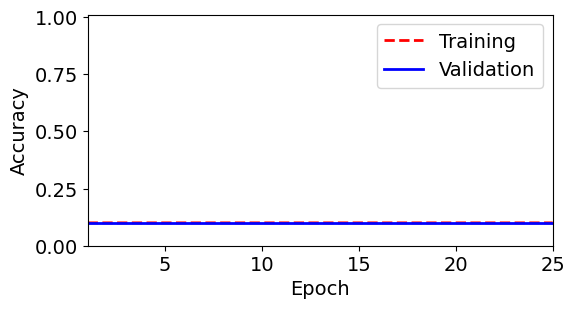

In [15]:
# evaluate
evaluate_model(name, model, eval_data)

### Now let's check if you fixed the issue!

Model: "Model0--Fixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 300)               235500    
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
469/469 [==============================] - 3s 6ms/step - loss: 34.3827 - accuracy: 0.7308 - val_loss: 16.2454 - val_accuracy: 0.7672
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 11.7323 - accuracy: 0.7966 - val_loss: 10.9668 - val_accuracy: 0.7866
Epoch 3/25
469/469 [===

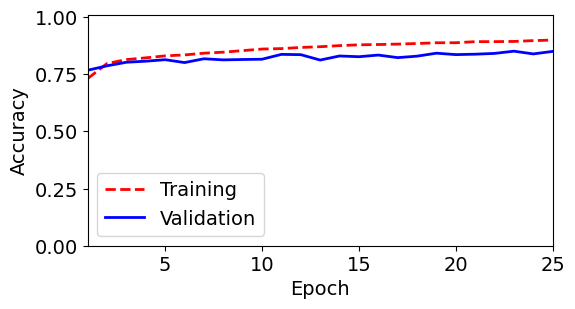

In [16]:
## create and compile the model for fixed=True, train it, then evaluate it
fixed = True
name, model = create_compile_model0(fixed, verbose=True) 

# train
eval_data = train_model(model, verbose=1)

# evaluate
evaluate_model(name, model, eval_data)

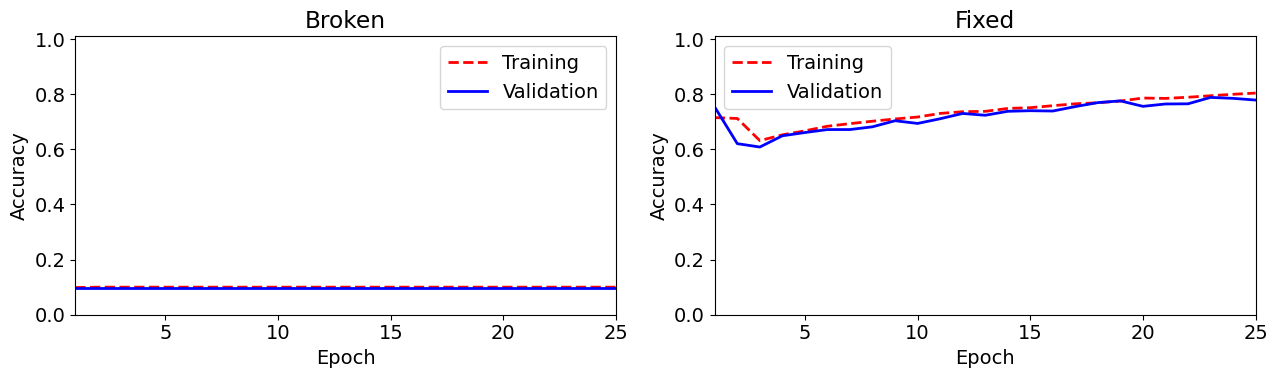

In [17]:
""" [ASSERTS] Check 2a completed. """

_, broken_model, _, broken_perf_data, _, fixed_model, _, fixed_perf_data = compile_train_eval_compare(create_compile_model0)
assert len(broken_model.layers) == len(fixed_model.layers) # check the layers have not changed (hint: layers are fine)

broken_tracc = broken_perf_data[:,1]
broken_valacc = broken_perf_data[:,3]
fixed_tracc = fixed_perf_data[:,1]
fixed_valacc = fixed_perf_data[:,3]

assert np.amax(broken_valacc) < 0.3 and np.amax(fixed_valacc) > 0.75 # loose threshold to check that it was fixed.

### Does the model works as expected now? Does it achieve about 85% accuracy (or at least 80%)?

In [18]:
# Yes, the model now works as expected. The training accuracy achieves 90.742%.
# The validation and testing accuracy achieve 84.920% and 85.180%, respectively.

### [Task 2b] (5 points) Just like task 2a, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

### Note: the model is different in some ways to model0 but most of these ways are unrelated to the problem you are asked to diagnose and fix!

In [19]:
def create_compile_model1(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    """ Remove the raise NotImplementedError lines, then move the if fixed branch to where you want to use it, and create a corresponding else (if necessary) to preserve 
    the broken functionality when fixed=False. For example:
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    Note: the 'raise NotImplementedError' lines may not match where you should put your 'if fixed' branch.
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    name = 'Model1--Fixed' if fixed else 'Model1--Broken'
    hidden_widths=[256, 128, 48]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros(), use_bias=False))

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Adam(learning_rate=0.1)

    # YOUR CODE HERE
    if fixed:
        opt = keras.optimizers.Adam(learning_rate=0.002)
    # raise NotImplementedError()
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [20]:
## create and compile the model for fixed=False, train it, then evaluate it
fixed = False
name, model = create_compile_model1(fixed) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model1--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 256)               200704    
                                                                 
 hidden_1 (Dense)            (None, 128)               32768     
                                                                 
 hidden_2 (Dense)            (None, 48)                6144      
                                                                 
 output (Dense)              (None, 10)                490       
                                                                 
Total params: 240,106
Trainable params: 240,106
Non-trainable params: 0
_________________________________________________________________


[Model1--Broken] Training Accuracy: 10.002%, Validation Accuracy: 9.620%
[Model1--Broken] Test loss: 2.30708, test accuracy: 10.380%


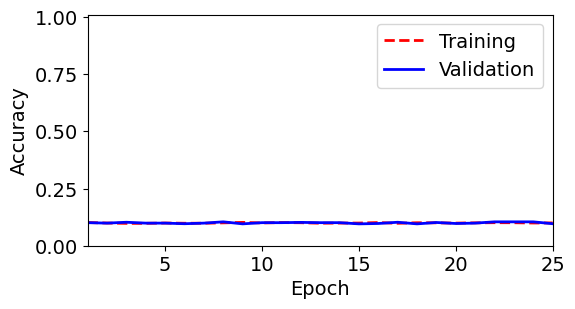

In [21]:
# evaluate
evaluate_model(name, model, eval_data)

### Let's check if you fixed the issue.

[Model1--Fixed] Training Accuracy: 88.285%, Validation Accuracy: 85.620%
[Model1--Fixed] Test loss: 0.43113, test accuracy: 85.900%


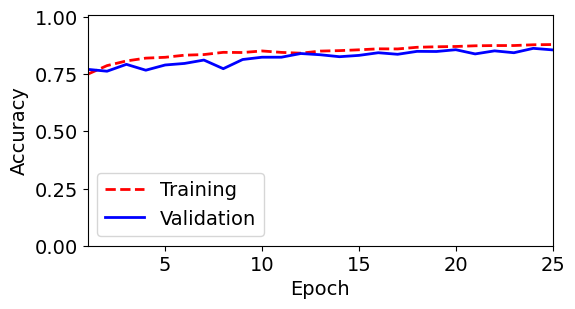

In [22]:
fixed = True
name, model = create_compile_model1(fixed, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

In [23]:
""" [ASSERTS] Check 2b completed. """

assert var_exists('create_compile_model1') # note: hidden tests will check accuracy is high enough for Fixed=True.


### [Task 2c] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [24]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The learning rate was too fast and the model could not learn.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

### [Task 2d] (5 points) Just like task 2a and task 2b, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [25]:
def create_compile_model2(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    """ Remove the raise NotImplementedError lines, then move the if fixed branch to where you want to use it, and create a corresponding else (if necessary) to preserve 
    the broken functionality when fixed=False. For example:
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    Note: the 'raise NotImplementedError' lines may not match where you should put your 'if fixed' branch.
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    name = 'Model2--Fixed' if fixed else 'Model2--Broken'
    hidden_widths=[400, 96]
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     use_bias=True))

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output', use_bias=False))

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    opt = keras.optimizers.RMSprop(learning_rate=1e-8)
    # YOUR CODE HERE
    if fixed:
        opt = keras.optimizers.RMSprop(learning_rate=0.0001)
    # raise NotImplementedError()
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [26]:
# create and compile the model for fixed=False, train it, then evaluate it
fixed = False
name, model = create_compile_model2(fixed) 

# train the model (hint you can set verbose to 1 to get more information during the training process)
eval_data = train_model(model)

Model: "Model2--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 400)               314000    
                                                                 
 hidden_1 (Dense)            (None, 96)                38496     
                                                                 
 output (Dense)              (None, 10)                960       
                                                                 
Total params: 353,456
Trainable params: 353,456
Non-trainable params: 0
_________________________________________________________________


[Model2--Broken] Training Accuracy: 16.373%, Validation Accuracy: 15.780%
[Model2--Broken] Test loss: 82.49289, test accuracy: 16.720%


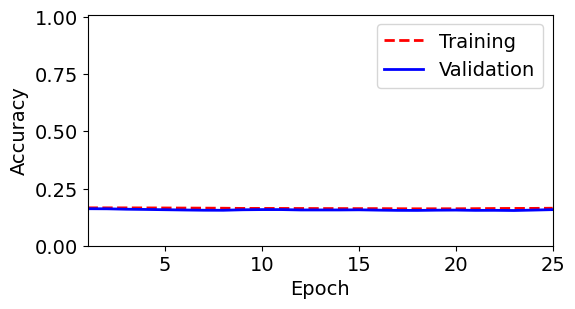

In [27]:
# evaluate
evaluate_model(name, model, eval_data)

### Let's check if you fixed the issue.

[Model2--Fixed] Training Accuracy: 91.468%, Validation Accuracy: 85.960%
[Model2--Fixed] Test loss: 0.60699, test accuracy: 86.120%


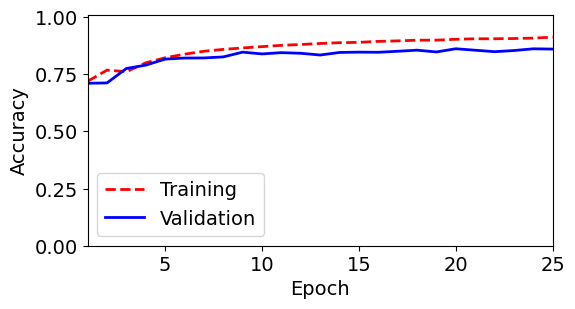

In [28]:
fixed = True
name, model = create_compile_model2(fixed, verbose=False)

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

In [29]:
""" [ASSERTS] Check 2d completed. """

assert var_exists('create_compile_model2') # note: hidden tests will check accuracy is high enough for Fixed=True.


### [Task 2e] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [30]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The RMSprop optimizer was employing a very slow learning rate. Changing the learning rate to 0.0001 yielded better results.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

## [Task 3] (30 points) Diagnosing Other Problems

### [Task 3a] (5 points) Just like in task 2, consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [31]:
def create_compile_model3(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    """ Remove the raise NotImplementedError lines, then move the if fixed branch to where you want to use it, and create a corresponding else (if necessary) to preserve 
    the broken functionality when fixed=False. For example:
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    Note: the 'raise NotImplementedError' lines may not match where you should put your 'if fixed' branch.
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    name = 'Model3--Fixed' if fixed else 'Model3--Broken'
    hidden_widths=[512, 128, 32, 24]

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     bias_initializer=keras.initializers.RandomNormal(stddev=0.001), use_bias=True))
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    if not fixed:
        model.add(keras.layers.Dense(num_outputs, activation='tanh', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
        
        opt = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.995, epsilon=1e-07, amsgrad=False)
        if verbose:
            model.summary()
            
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
        opt = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.995, epsilon=1e-07, amsgrad=False)
        
        if verbose:
            model.summary()
        
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [32]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model3(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=1)

Model: "Model3--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 512)               401920    
                                                                 
 hidden_1 (Dense)            (None, 128)               65664     
                                                                 
 hidden_2 (Dense)            (None, 32)                4128      
                                                                 
 hidden_3 (Dense)            (None, 24)                792       
                                                                 
 output (Dense)              (None, 10)                250       
                                                                 
Total params: 472,754
Trainable params: 472,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
469/469 [==========================

[Model3--Broken] Training Accuracy: 10.000%, Validation Accuracy: 10.260%
[Model3--Broken] Test loss: nan, test accuracy: 9.740%


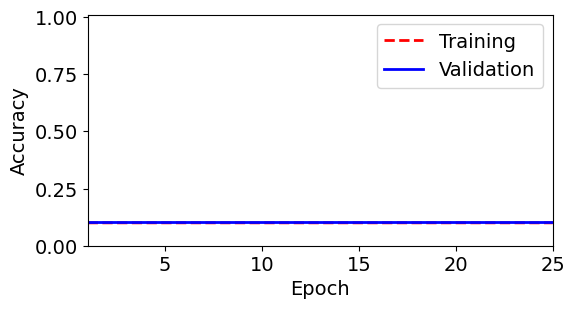

In [33]:
# evaluate
evaluate_model(name, model, eval_data)

### Let's check if you fixed the issue.

[Model3--Fixed] Training Accuracy: 92.332%, Validation Accuracy: 88.280%
[Model3--Fixed] Test loss: 0.37001, test accuracy: 88.320%


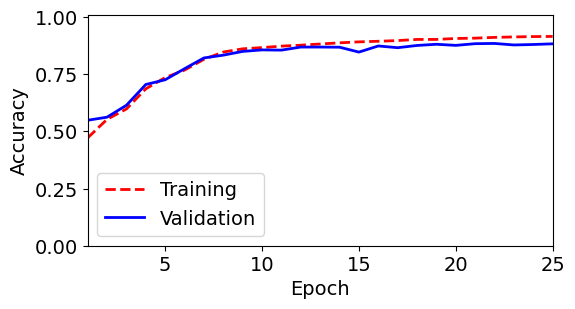

In [34]:
name, model = create_compile_model3(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

In [35]:
""" [ASSERTS] Check 3a completed. """

assert var_exists('create_compile_model3') # note: hidden tests will check accuracy is high enough for Fixed=True.


###  [Task 3b] (5 points) Explain what was the problem. (One sentence or two is fine.)

In [36]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The output activation function was changed to softmax to get better results in our multiclass classification problem. The broken model uses tanh.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

### [Task 3c] (5 points) Consider the following model. It has one obvious problem which prevents the model from learning: can you figure out what it is? Fix it by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation!

In [37]:
def create_compile_model4(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    """ Remove the raise NotImplementedError lines, then move the if fixed branch to where you want to use it, and create a corresponding else (if necessary) to preserve 
    the broken functionality when fixed=False. For example:
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    Note: the 'raise NotImplementedError' lines may not match where you should put your 'if fixed' branch.
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    name = 'Model4--Fixed' if fixed else 'Model4--Broken'
    hidden_widths=[512, 128, 3, 24]

    # YOUR CODE HERE
    if fixed:
        hidden_widths = [512, 128, 32, 24]
    # raise NotImplementedError()
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))
        
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros(), use_bias=True))
    
    opt = keras.optimizers.Nadam(learning_rate=0.001)

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [38]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model4(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=1)

Model: "Model4--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 512)               401920    
                                                                 
 hidden_1 (Dense)            (None, 128)               65664     
                                                                 
 hidden_2 (Dense)            (None, 3)                 387       
                                                                 
 hidden_3 (Dense)            (None, 24)                96        
                                                                 
 output (Dense)              (None, 10)                250       
                                                                 
Total params: 468,317
Trainable params: 468,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
469/469 [==========================

[Model4--Broken] Training Accuracy: 10.000%, Validation Accuracy: 10.080%
[Model4--Broken] Test loss: 2.30261, test accuracy: 9.920%


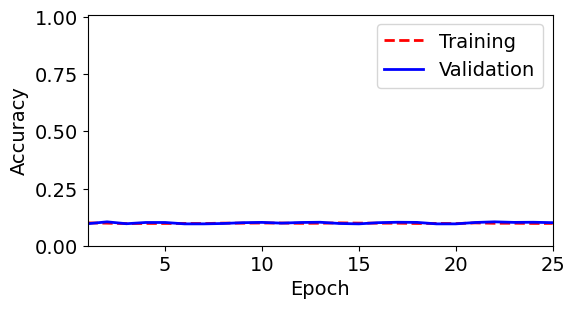

In [39]:
# evaluate
evaluate_model(name, model, eval_data)

### Let's check if you fixed the issue.

[Model4--Fixed] Training Accuracy: 91.807%, Validation Accuracy: 88.480%
[Model4--Fixed] Test loss: 0.34998, test accuracy: 87.900%


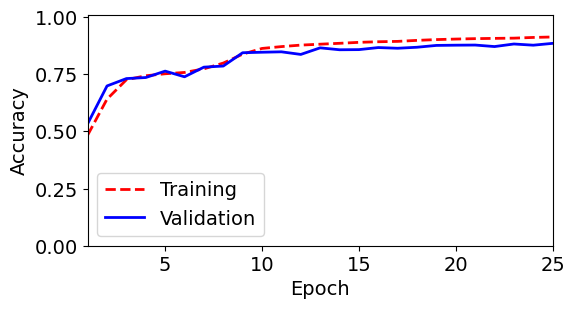

In [40]:
name, model = create_compile_model4(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

In [41]:
""" [ASSERTS] Check 3c completed. """

assert var_exists('create_compile_model4') # note: hidden tests will check accuracy is high enough for Fixed=True.


### [Task 3d] (5 points) Explain what was the problem. (A sentence or two is fine.)

In [42]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# Hidden widths had 3 in the 3rd position instead of 32. This causes the model to miss a lot of information.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

### [Task 3e] (5 points) Consider the following model. It has several problems which prevent it from learning: can you figure out what those problems are? Fix them by adding code to the 'if fixed:'' branch. Make sure that if fixed=False you do not change the implementation! You can have more than one "if fixed:" branch if necessary.

In [43]:
def create_compile_model5(fixed, input_shape=784, num_outputs=10, verbose=True):
    
    
    """ Remove the raise NotImplementedError lines, then move the if fixed branch to where you want to use it, and create a corresponding else (if necessary) to preserve 
    the broken functionality when fixed=False. For example:
    #if fixed:
        ###* put your code here (~1-2 lines) *###

    Note: the 'raise NotImplementedError' lines may not match where you should put your 'if fixed' branch.
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    name = 'Model5--Fixed' if fixed else 'Model5--Broken'
    hidden_widths=[256, 128, 24]
    
    if fixed:
        hidden_widths=[512,128,32,24]
    
    model = keras.models.Sequential(name=name)

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    if not fixed:
        model.add(keras.Input(shape=(input_shape,))) 
    else:
        model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        # YOUR CODE HERE
        # raise NotImplementedError()
        if not fixed:
            model.add(keras.layers.Dense(hw, activation='sigmoid', name='hidden_{}'.format(i)))
        else:
            model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i)))

    # YOUR CODE HERE
    # raise NotImplementedError()
    if not fixed:
        model.add(keras.layers.Dense(num_outputs, activation='linear', name='output',
                                bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                kernel_initializer=keras.initializers.Zeros(), use_bias=False))
    else:
        model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                bias_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                kernel_initializer=keras.initializers.Zeros(), use_bias=True))

    # YOUR CODE HERE
    # raise NotImplementedError()
    
    opt = keras.optimizers.Nadam(learning_rate=0.01, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    # YOUR CODE HERE
    if fixed:
        opt = keras.optimizers.Nadam(learning_rate=0.001, beta_2=0.999, epsilon=1e-07, clipvalue=1.0)
    # raise NotImplementedError()
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [44]:
# create and compile the model for fixed=False, train it, then evaluate it
name, model = create_compile_model5(False) 

# train the model (hint you can set verbose get more or less information during the training process)
eval_data = train_model(model, verbose=0)

Model: "Model5--Broken"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 256)               200960    
                                                                 
 hidden_1 (Dense)            (None, 128)               32896     
                                                                 
 hidden_2 (Dense)            (None, 24)                3096      
                                                                 
 output (Dense)              (None, 10)                240       
                                                                 
Total params: 237,192
Trainable params: 237,192
Non-trainable params: 0
_________________________________________________________________


[Model5--Broken] Training Accuracy: 10.000%, Validation Accuracy: 10.260%
[Model5--Broken] Test loss: nan, test accuracy: 9.740%


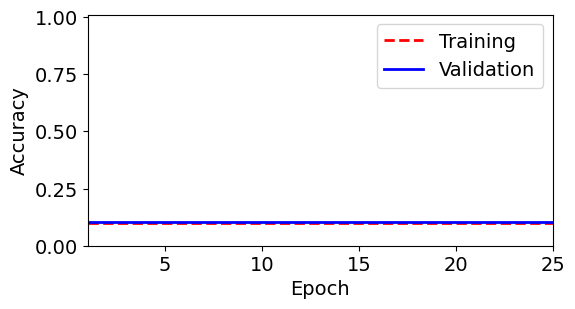

In [45]:
# evaluate
evaluate_model(name, model, eval_data)

### Let's check if you fixed the issue.

[Model5--Fixed] Training Accuracy: 94.008%, Validation Accuracy: 88.760%
[Model5--Fixed] Test loss: 0.36447, test accuracy: 88.700%


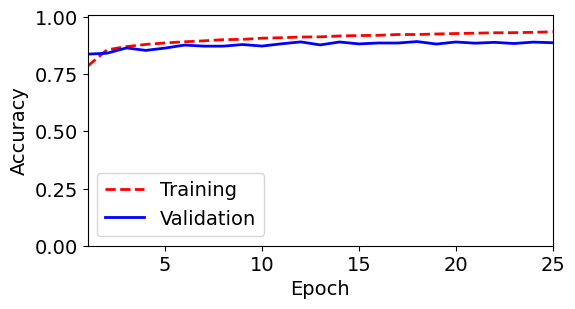

In [46]:
name, model = create_compile_model5(True, verbose=False) 

eval_data = train_model(model)
evaluate_model(name, model, eval_data)

In [47]:
""" [ASSERTS] Check 3e completed. """

assert var_exists('create_compile_model5') # note: hidden tests will check accuracy is high enough for Fixed=True.


### [Task 3f] (5 points) Explain what was the problem. If there are multiple issues, describe all of them. (A sentence or two for each issue is fine.)

In [48]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The hidden widths values were too small and not spaced out enough. Instead, I changed them to [512,128,32,24] as in previous tasks.
# The dense layers using the hidden widths were using the sigmoid activation function instead of the relu.
# The output layer was using a linear activation function instead of the softmax activation function for multiple outputs. The "use_bias" was also set to false 
# when it should be true like previous tasks.
# The learning rate was also too fast. Slowing it down to 0.001 yielded higher results.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

---
# [Task 4] (25 points) Training CNNs

### In this task, you will train a convolutional neural network with an architecture you define. The goal is (of course) to train the best possible model, but the constraint is that the number of parameters must not exceed 500k (500,000). We will aim to achieve test/val accuracy above 88%.

### If you do this on a machine with a GPU, it will be very fast. Otherwise it may take 5 or 10 minutes to train the model for a few epochs, so we will use a subset of the training data for developing and testing the model.

#### Note: it is possible to achieve reasonably high accuracy (above 90%) with only about 50k parameters.

### To use a convolutional architecture we need to reshape the data

In [49]:
use_subset = True
tr_sz = 5000

use_subset = False # uncomment this line to use the full data
# YOUR CODE HERE
# raise NotImplementedError()

# reshape for use with CNN
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

cnn_dataset = (train_x, train_y, val_x, val_y, test_x, test_y)
if use_subset:
    cnn_dataset = (train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

### [Task 4a] (15 points) Fill in the implementation of create_compile_cnn() below with your chosen architecture. Ensure the total number of parameters chosen does not exceed 500k. You can look for insipiration for architectures on the web (or in books) if you like, but in that case you must provide a reference.

In [50]:
def create_compile_cnn(input_shape=(28, 28, 1), num_outputs=10, verbose=False):
    name = 'CNN'
    assert train_x.shape[1:] == input_shape # sanity check
    
    model = keras.models.Sequential(name=name)

    """ Put your code here (10-20 lines).
    You can use any architecture but the output layer (with softmax activation is fixed). 
    You can also use whatever optimizer 'opt' you want (with your choice hyperparameters values)
    But the call to model.summary() must show that the number of parameters is within the constraint.
    """
    ### Note: you can import layers from keras.layers to make the code more compact.
    ###* put your code here (~10-20 lines) *###
    
    # YOUR CODE HERE
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    # raise NotImplementedError()
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [51]:
name, cnn_model = create_compile_cnn(verbose=True)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128     

In [52]:
# note: you can change the number of epochs to train as long as it's reasonable
epochs = 50 if use_subset else 5

""" You can add code here or edit it to change the number of epochs for example or the batch size, etc.
"""
# YOUR CODE HERE
# raise NotImplementedError()

# note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
eval_data = train_model(cnn_model, max_epochs=epochs, batch_size=256, dataset=cnn_dataset, verbose=1)

Epoch 1/5
235/235 [==============================] - 8s 15ms/step - loss: 0.6280 - accuracy: 0.7838 - val_loss: 0.3848 - val_accuracy: 0.8612
Epoch 2/5
235/235 [==============================] - 3s 12ms/step - loss: 0.4095 - accuracy: 0.8517 - val_loss: 0.3392 - val_accuracy: 0.8808
Epoch 3/5
235/235 [==============================] - 2s 10ms/step - loss: 0.3594 - accuracy: 0.8708 - val_loss: 0.3142 - val_accuracy: 0.8848
Epoch 4/5
235/235 [==============================] - 3s 12ms/step - loss: 0.3307 - accuracy: 0.8798 - val_loss: 0.3073 - val_accuracy: 0.8876
Epoch 5/5
235/235 [==============================] - 3s 13ms/step - loss: 0.3103 - accuracy: 0.8861 - val_loss: 0.2956 - val_accuracy: 0.8940


#### Let's evaluate your CNN model. Does it achieve 88+% val/test accuracy?
#### *note: once you are confident in your model architecture, you MUST switch back to the full dataset*
#### to train the final version of the model (depending on your chosen architecture this could take 5-10 minutes if you are not on machine with GPU)
#### make sure it does not take too long to train the model as this could be a problem for grading (e.g., <10min on a machine with a CPU only)

[CNN] Training Accuracy: 90.810%, Validation Accuracy: 89.400%
[CNN] Test loss: 0.29006, test accuracy: 89.300%


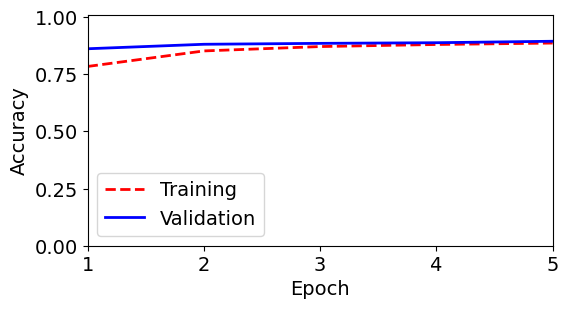

In [53]:
evaluate_model(name, cnn_model, eval_data)

In [54]:
from tensorflow.python.keras.utils import layer_utils

""" [ASSERTS] Check 4a completed. """

assert var_exists('cnn_model') and isinstance(cnn_model, keras.Model)
trainable_count = layer_utils.count_params(cnn_model.trainable_weights)
assert trainable_count <= 500 * 1000


### [Task 4b] (5 points) How long (in seconds/minutes) did your model take to train on the full dataset? Did you use a GPU?

In [55]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The model took around 10-30 seconds to train. I did not use a GPU, though I have one available.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

### [Task 4c] (5 points) Explain how you decided on this architecture. (2-3 sentences is okay.) If you took inspiration from resources such as books/webpages, it's okay but you should (of course) include a reference in your answer.

In [56]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# The above architecture was employed using common practice for CNNs for image classification.
# It is made up of alternating conovlutional and max pooling layers to extract features.
# The output is a fully connected dense layer using the softmax activation function to classify
# each of the FashionMNIST classes. Batch normalization and dropout are used for regularization and 
# stability during training.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

---
# [Task 5] \<*For CAI6108MLE Only*\> (25 points) CNN vs. Data Augmentation

### In this task we want to understand the impact of data augmentation on model quality. We pretend that we only have access to 2k examples from the training set and then multiply its size (by 5X) using data augmentation.

### The idea is to compare the performance of three models (all of which using your CNN architecture from Task 4): (1) the CNN trained on tr_x, ty_y (2k examples), (2) the CNN trained on the augmented data (20k examples), and (3) the CNN trained on 20k examples from the fashion-MNIST training set.

### [Task 5a] (15 points) Complete the code below to use data augmentation to produce a dataset of size 'data_aug_sz' from the tr_x and tr_y. You can use tf.keras' ImageDataGenerator with parameters chosen by you. 

In [57]:
from keras.preprocessing.image import ImageDataGenerator

# dataset 1 -- 2k examples from fmnist
tr_sz = 2000
cnn_dataset1 = (train_x[:tr_sz], train_y[:tr_sz], val_x, val_y, test_x, test_y)

# dataset 2 -- data augmentation (20k) starting from 2k examples from fmnist
tr_x = train_x[:tr_sz]
tr_y = train_y[:tr_sz]

data_aug_sz = 20000

""" Put your code here (10-15 lines).
"""
### Note: you should look closely at the documentation of ImageDataGenerator (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
### to make sure you do *not* do strange things (e.g., it might not be a good idea to have vertical_flip=True, etc.)...
### Store the augmented data into 'aug_tr_x' and 'aug_tr_y'

# YOUR CODE HERE
def augment_data(tr_x, tr_y, data_aug_sz):
    # https://www.kaggle.com/code/venkatkrishnan/data-augmentation-deep-learning
    aug = ImageDataGenerator(rotation_range=50, width_shift_range=0.01, height_shift_range=0.01)
    
    aug.fit(tr_x)
    
    aug_data = []
    aug_labels = []
    batch_size = 16
    batches = 0
    
    while len(aug_data) < data_aug_sz:
        for x_batch, y_batch in aug.flow(tr_x, tr_y, batch_size=batch_size):
            aug_data.extend(x_batch)
            aug_labels.extend(y_batch)
            batches += 1
            if batches * batch_size >= data_aug_sz:
                break
    
    aug_data = np.array(aug_data)
    aug_labels = np.array(aug_labels)
    
    return aug_data, aug_labels

aug_tr_x, aug_tr_y = augment_data(tr_x, tr_y, data_aug_sz)
# raise NotImplementedError()

# store the result
cnn_dataset2 = (aug_tr_x, aug_tr_y, val_x, val_y, test_x, test_y)
assert aug_tr_x.shape[0] == data_aug_sz and aug_tr_y.shape[0] == data_aug_sz

# dataset 3 -- 20k examples
cnn_dataset3 = (train_x[:data_aug_sz], train_y[:data_aug_sz], val_x, val_y, test_x, test_y)
assert aug_tr_x.shape == cnn_dataset3[0].shape


---------- Model 1 (train size: 2000) -----------
[CNN] Training Accuracy: 95.500%, Validation Accuracy: 84.700%
[CNN] Test loss: 0.42221, test accuracy: 85.140%


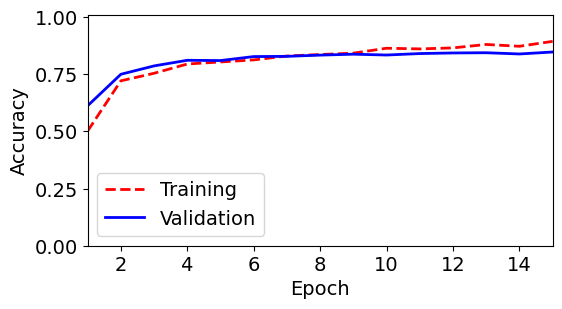


---------- Model 2 Data Augmented (train size: 20000) -----------
[CNN] Training Accuracy: 94.515%, Validation Accuracy: 80.920%
[CNN] Test loss: 0.59504, test accuracy: 81.560%


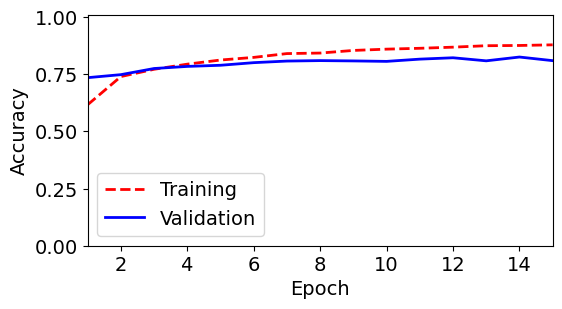


---------- Model 3 (train size: 20000) -----------
[CNN] Training Accuracy: 93.870%, Validation Accuracy: 89.940%
[CNN] Test loss: 0.27681, test accuracy: 90.360%


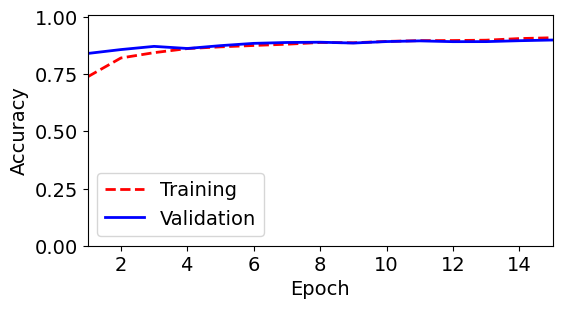

In [58]:
### Now let's evaluate all three models

datasets = (cnn_dataset1, cnn_dataset2, cnn_dataset3)
names = ['Model 1 (train size: {})'.format(tr_sz), 'Model 2 Data Augmented (train size: {})'.format(data_aug_sz),
         'Model 3 (train size: {})'.format(data_aug_sz)]

for i, dataset in enumerate(datasets):
    name, cnn_model = create_compile_cnn(verbose=False)

    # note: you can change how you call train_model as necessary (e.g., if you want to change the batch_size)
    eval_data = train_model(cnn_model, max_epochs=15, dataset=dataset, verbose=0)  

    print('\n---------- {} -----------'.format(names[i]))
    evaluate_model(name, cnn_model, eval_data)

### [Task 5b] (10 points) What do you conclude about data augmentation? Does it help if you don't have enough data? Is it as good as having more real data? (A few sentences is fine.)

In [59]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
# Augmentation can help generalize data better from what I've seen in other cases, but not this one. Model 1 with less data outperforms Model 2 suggesting that 
# augmentation may not always help. Model 3 outperforms both Model 1 and 2 with the highest validation/testing accuracy. The results for Model 2 and 3 also suggest that
# having more real data is probably better than augmented data.

# YOUR CODE HERE
# raise NotImplementedError()
#

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"